# Capstone Project - The Battle of Neighborhoods
## Indian Restaurants in New York City  
Indians constitute one of the largest and fastest growing ethnicities in the New York city of the United States. 
The Indian population also represents the second-largest metropolitan within the New York City. New York City is a home to nearly 8.6 million people. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States. People from all over India live in New York city, with diverse culture, there are many Indian restaurants in New York City, each belonging to different categories like North Indian food or south Indian and many more.

The idea of this project is to help people to search Indian restaurant in New York city, choose the right location by providing data, rating and different cuisines.To provide people the necessary information I'llbe combining New York city data that contains list of Boroughs, Neighborhoods along with their latitude and longitude and Foursquare API.

Data Set:
As part of this project, we will list and visualize all major parts of New York City that has great Indian restaurants.

i. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data: https://cocl.us/new_york_dataset

ii. Indian restaurants in each neighborhood of New York city. Data: Foursquare API

iii. GeoSpace data Data: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

In [12]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [22]:
CLIENT_ID = 'VKHDRDAMEYQU0TOUQTHZE1RRRZ1Q1VGW5CFNOFQSBYLEPKPE' # your Foursquare ID
CLIENT_SECRET = '5L4JHF1ATQRRMMGG34FTSPLR0JBCOXHVL52PEEIZHXS2LIGA' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VKHDRDAMEYQU0TOUQTHZE1RRRZ1Q1VGW5CFNOFQSBYLEPKPE
CLIENT_SECRET:5L4JHF1ATQRRMMGG34FTSPLR0JBCOXHVL52PEEIZHXS2LIGA


In [14]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [23]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VKHDRDAMEYQU0TOUQTHZE1RRRZ1Q1VGW5CFNOFQSBYLEPKPE' # your Foursquare ID
    CLIENT_SECRET = '5L4JHF1ATQRRMMGG34FTSPLR0JBCOXHVL52PEEIZHXS2LIGA' # your Foursquare Secret
    VERSION = '20180605'

    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [24]:
def get_venue_details(venue_id):
    CLIENT_ID = 'VKHDRDAMEYQU0TOUQTHZE1RRRZ1Q1VGW5CFNOFQSBYLEPKPE' # your Foursquare ID
    CLIENT_SECRET = '5L4JHF1ATQRRMMGG34FTSPLR0JBCOXHVL52PEEIZHXS2LIGA' # your Foursquare Secret
    VERSION = '20180605'
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [25]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [26]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [27]:
new_york_data.shape

(306, 4)

total of 306 different Neighborhoods in New York

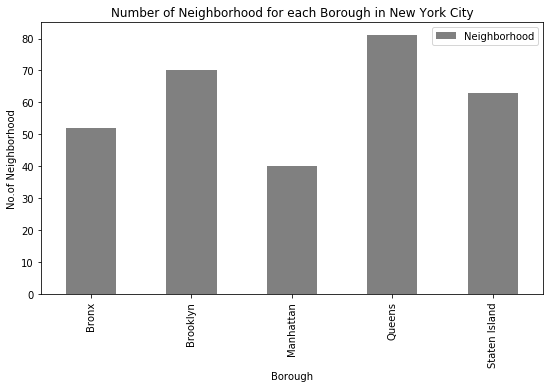

In [28]:
plt.figure(figsize=(9,5))
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Neighborhood')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='gray')
plt.legend()
plt.show()

Queens has highest number of neighborhoods  
Now we check the Indian resturants for each Neighborhood

In [29]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:1
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:1
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:1
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:1
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [31]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [32]:
indian_rest_ny.shape

(156, 4)

We have total 156 india restaurant in New York City

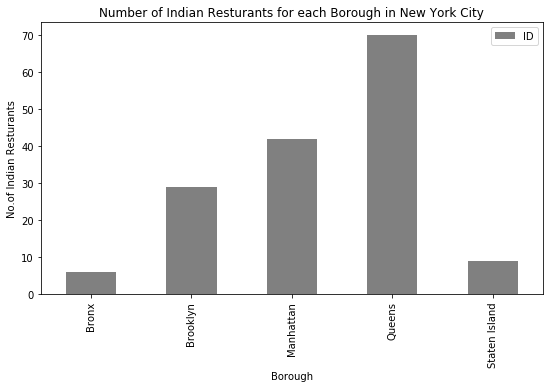

In [38]:
plt.figure(figsize=(9,5))
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar',color='gray')
plt.title('Number of Indian Restaurants for each Borough in New York City')
plt.xlabel('Borough')
plt.ylabel('No.of Indian Resturants')
plt.legend()
plt.show()

Queens has the more no of indian restaurants

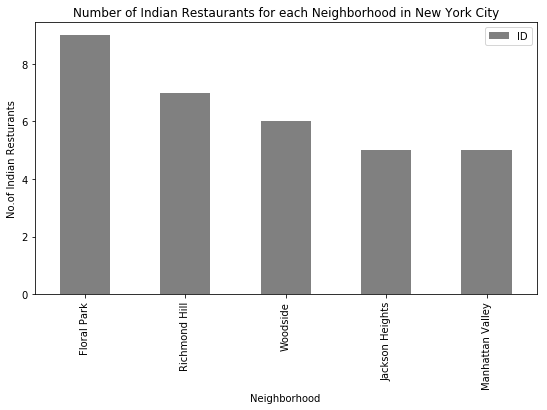

In [39]:
plt.figure(figsize=(9,5))
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar',color='gray')
plt.title('Number of Indian Restaurants for each Neighborhood in New York City')
plt.xlabel('Neighborhood')
plt.ylabel('No.of Indian Resturants')
plt.legend()
plt.show()

now comparing all the neighborhoods of the queens we see that Floral park has the highest no of restaurants

In [40]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
107,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
108,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
112,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
113,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [41]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      4     8.1    11
( 1 / 156 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 156 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.1     9
( 3 / 156 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.9     3
( 4 / 156 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 156 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.2    26
( 6 / 156 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [42]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.1,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [43]:
indian_rest_stats_ny.shape

(50, 7)

save this to csv file. 

In [45]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.1,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [46]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [47]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [ ]:
we will check now restaurants with maximum likes, highest rating, Tips

In [48]:
#maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.8
Tips                                 258
Name: 41, dtype: object

In [49]:
#highest Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                584
Rating                                 9
Tips                                 145
Name: 45, dtype: object

In [50]:
# Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.8
Tips                                 258
Name: 41, dtype: object

In [51]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.00
13,Greenwich Village,8.90
32,West Village,8.85
18,Midtown,8.80
3,Chelsea,8.80
19,Murray Hill,8.70
10,Fort Greene,8.60
20,North Side,8.60
26,South Side,8.60
25,Roosevelt Island,8.40


In [52]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.227273
1,Brooklyn,7.408696
0,Bronx,6.620000


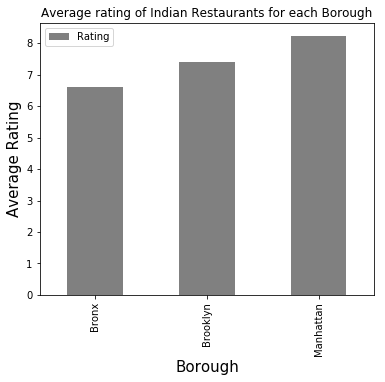

In [54]:
plt.figure(figsize=(6,5))
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar',color='gray')
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.legend()
plt.show()

In [55]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Chelsea,8.80
10,Fort Greene,8.60
13,Greenwich Village,8.90
18,Midtown,8.80
19,Murray Hill,8.70
20,North Side,8.60
26,South Side,8.60
28,Tribeca,9.00
32,West Village,8.85


In [57]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.80
1,Staten Island,Chelsea,40.594726,-74.189560,8.80
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.60
3,Manhattan,Greenwich Village,40.726933,-73.999914,8.90
4,Manhattan,Midtown,40.754691,-73.981669,8.80
5,Manhattan,Murray Hill,40.748303,-73.978332,8.70
6,Queens,Murray Hill,40.764126,-73.812763,8.70
7,Brooklyn,North Side,40.714823,-73.958809,8.60
8,Brooklyn,South Side,40.710861,-73.958001,8.60
9,Manhattan,Tribeca,40.721522,-74.010683,9.00


In [58]:
#  map 
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)

In [59]:
#incidents in the dataframe
incidents = folium.map.FeatureGroup()
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [61]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [62]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)

### Conclusion
Queens has the more no of restaurant  
Manhattan has highest rating